In [69]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import categorical_crossentropy
from sklearn import metrics
import copy
import random
from sklearn.ensemble import IsolationForest

In [70]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype("float32")
test_images = test_images.reshape((10000, 28, 28,1)).astype("float32")

# Normalize between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

train_labels[0]

9

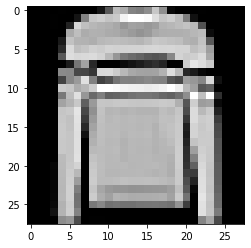

(None, 2)

In [71]:
first_image = train_images[5]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show(),train_labels[5]

In [72]:
num_classes=10
train_labels1 = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels1 = tf.keras.utils.to_categorical(test_labels, num_classes)

In [73]:
#Create a model
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])
lq.models.summary(model)

+sequential_1 stats--------------------------------------------------------------------------------------------+
| Layer                   Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                               (bit)                          x 1       x 1     (kB)                          |
+--------------------------------------------------------------------------------------------------------------+
| quant_conv2d_6                    -  (-1, 26, 26, 128)      1152         0     0.14           0       778752 |
| batch_normalization_9             -  (-1, 26, 26, 128)         0       256     1.00           0            0 |
| quant_conv2d_7                    1  (-1, 26, 26, 128)    147456         0    18.00    99680256            0 |
| max_pooling2d_3                   -  (-1, 13, 13, 128)         0         0        0           0            0 |
| batch_normalization_10            -  (-1, 13, 13, 128)         0       256     1.00           

In [74]:
#Train the model
model.compile(
    tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

trained_model = model.fit(
    train_images, 
    train_labels1,
    batch_size=50, 
    epochs=20,
    validation_data=(test_images, test_labels1),
    shuffle=True
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 347us/sample - loss: 0.7762 - accuracy: 0.8052 - val_loss: 0.6591 - val_accuracy: 0.8113
Epoch 2/20
60000/60000 [==============================] - 19s 321us/sample - loss: 0.6261 - accuracy: 0.8712 - val_loss: 0.5941 - val_accuracy: 0.8521
Epoch 3/20
60000/60000 [==============================] - 19s 323us/sample - loss: 0.5834 - accuracy: 0.8900 - val_loss: 0.5325 - val_accuracy: 0.8973
Epoch 4/20
60000/60000 [==============================] - 20s 328us/sample - loss: 0.5575 - accuracy: 0.9011 - val_loss: 0.5493 - val_accuracy: 0.8918
Epoch 5/20
60000/60000 [==============================] - 20s 327us/sample - loss: 0.5394 - accuracy: 0.9094 - val_loss: 0.6123 - val_accuracy: 0.8798
Epoch 6/20
60000/60000 [==============================] - 20s 326us/sample - loss: 0.5200 - accuracy: 0.9189 - val_loss: 0.5001 - val_accuracy: 0.9114
Epoch 7/20
60000/60000 [====================

0.97793335
0.9248


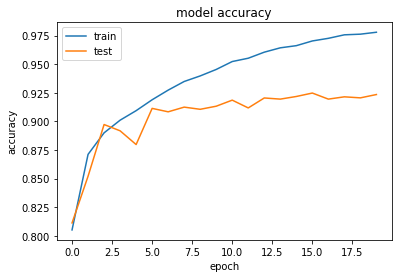

In [75]:
#Plot accuracy with training epochs
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.39977755467096965
0.4925950773060322


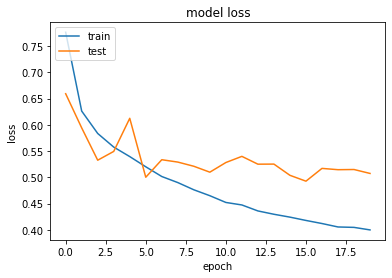

In [76]:
#Plot loss with training epochs
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

In [77]:
#Check model test accuracy
model.evaluate(test_images[:], test_labels1[:], batch_size=128)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5073307799339295, 0.9235]

In [78]:
from sklearn import metrics
y_pred = model.predict(test_images[:])
y_classes_pred = [np.argmax(element) for element in y_pred]
y_classes_act = [np.argmax(element) for element in test_labels1[:]]
confusion_matrix=metrics.confusion_matrix(test_labels, y_classes_pred)
print(confusion_matrix)
count=0
for i in range (0,len(test_labels1)):
    if (y_classes_pred[i] == test_labels[i]):
        count = count + 1
print(count/len(test_labels1))
acc_drop_l = []
for i in range(len(confusion_matrix)):
    acc_drop_l.append(confusion_matrix[i][i]/sum(confusion_matrix[i]))
print("Class specific accuracies : ",acc_drop_l) 

[[889   0  13  23   6   1  56   0  12   0]
 [  3 983   0  10   1   0   1   0   2   0]
 [ 19   0 896   7  42   0  35   0   1   0]
 [ 15   3   6 931  26   0  13   0   5   1]
 [  0   0  48  14 911   0  27   0   0   0]
 [  0   0   0   0   0 981   0  12   0   7]
 [114   1  62  24  75   0 714   0  10   0]
 [  0   0   0   0   0   3   0 970   0  27]
 [  2   1   2   2   0   2   2   2 986   1]
 [  0   0   0   0   0   7   0  18   1 974]]
0.9235
Class specific accuracies :  [0.889, 0.983, 0.896, 0.931, 0.911, 0.981, 0.714, 0.97, 0.986, 0.974]


In [79]:
#Save the weights of thw trained model
cc_weight = model.get_weights()

In [82]:
# sub-sampling from test samples
NumSamplePerClass = 125
test_labels_new = []
test_images_new = []
l = {}
for i in range(len(test_labels1[0])):
    l[i] = 0
for i in range(len(test_labels1)):
    b = np.argmax(test_labels1[i])
    if l[b]<NumSamplePerClass:
        test_images_new.append(test_images[i])
        test_labels_new.append(test_labels1[i])
        l[b] = l[b] + 1
test_images_new = np.array(test_images_new)
test_labels_new = np.array(test_labels_new)
len(test_labels_new)

1250

In [83]:
# Gradient calculation with respect to trainable weights
def step(X, y):
    with tf.GradientTape() as tape:
        pred = model(X)
        loss = tf.keras.losses.categorical_crossentropy(y, pred)
    grads = tape.gradient(loss, model.trainable_weights)
    return grads
    
grad = step(test_images_new,test_labels_new)

In [84]:
#weight layers and trainable weight layers mapping
h=[[],[]]
for i in range(len(model.weights)):
    for j in range(len(model.trainable_weights)):
        if model.weights[i].name == model.trainable_weights[j].name and (('conv' in model.trainable_weights[j].name) or ('dense' in model.trainable_weights[j].name)):
            h[0].append(j)
            h[1].append(i)
"Weight layers ",h[1]," mapped to trainable weight layers ", h[0]

('Weight layers ',
 [0, 4, 8, 12, 16, 20, 24, 28, 32],
 ' mapped to trainable weight layers ',
 [0, 2, 4, 6, 8, 10, 12, 14, 16])

# Layer selection #

In [18]:
xvals = []
yvals = []
zvals = []

In [37]:
# Top-k gradient weight/bit flips in each layer and the corresponding loss ranked
loss_list=[]
k=1000
for i in h[0]:
    result = tf.math.top_k(abs(grad[i].numpy().flatten()), k=k)
    top_k_grad, top_k_index = result.values.numpy(), result.indices.numpy()
    layer_index = h[1][h[0].index(i)]
    clean_weight = model.get_weights()
    w_new = copy.deepcopy(clean_weight)
    w_f = w_new[layer_index].flatten()
    for j in list(top_k_index):
        if w_f[j] >= 0:
            w_f[j] = -1
        else:
            w_f[j] = 1
    w_new[layer_index] = w_f.reshape(w_new[layer_index].shape)
    model.set_weights(w_new)
    x, y = test_images_new, test_labels_new
    pred = model.predict(x)
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss_list.append([cce(y,pred).numpy(), layer_index])
    model.set_weights(cc_weight)                   
loss_list.sort(reverse=True)
loss_list

[[2.100489, 0],
 [1.5402542, 32],
 [0.4875853, 4],
 [0.48469475, 28],
 [0.48097983, 12],
 [0.47898567, 8],
 [0.47704178, 20],
 [0.47520748, 16],
 [0.4733471, 24]]

In [38]:
# Collect data for different k-values for top-3 most contributing layers
xvals.append(loss_list[0])
yvals.append(loss_list[1])   
zvals.append(loss_list[2]) 
xvals,yvals,zvals

([[0.620985, 0],
  [0.77055734, 0],
  [0.926402, 0],
  [1.0544617, 0],
  [1.4072466, 0],
  [1.9051194, 0],
  [2.185567, 0],
  [2.0909038, 0],
  [2.1357198, 0],
  [2.100489, 0]],
 [[0.5474017, 32],
  [0.6313715, 32],
  [0.72143507, 32],
  [0.8221999, 32],
  [0.92870957, 32],
  [1.0448203, 32],
  [1.1611885, 32],
  [1.2813407, 32],
  [1.409181, 32],
  [1.5402542, 32]],
 [[0.47942993, 8],
  [0.47931594, 8],
  [0.4817135, 8],
  [0.48030934, 12],
  [0.48336238, 4],
  [0.48341286, 8],
  [0.48291388, 28],
  [0.48835325, 4],
  [0.48817536, 4],
  [0.4875853, 4]])

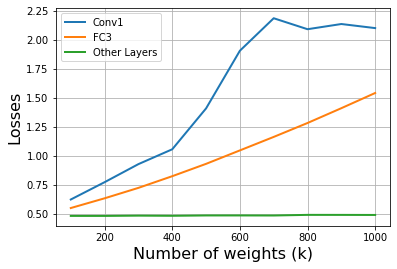

In [39]:
# Plot losses for top-k flips with various k-values
y=[100,200,300,400,500,600,700,800,900,1000]
x1 = np.transpose(xvals)[0]
x2 = np.transpose(yvals)[0]
x3 = np.transpose(zvals)[0]
plt.plot(y,x1,label = "Conv1",linewidth=2)
plt.plot(y,x2,label = "FC3",linewidth=2)
plt.plot(y,x3,label = "Other Layers",linewidth=2)
# plt.title("Losses due to layer-wise top-k gradient weight flips")
plt.ylabel('Losses', fontsize=16)
plt.xlabel('Number of weights (k)', fontsize=16)
plt.legend()
plt.grid()
# plt.savefig('Results/LayerSelection.pdf')
plt.show()

# Layer chosen based on the plotted data: conv1, fc3

# Selecting weight subset with gradient outliers: #

In [85]:
# Outlier selection
VulnerableLayers = [0,16]
solSpace = 1000 #solution space
f=0
cnt1=[] #weight indexes with gradient outliers
for i in VulnerableLayers:
    cont = solSpace/len(VulnerableLayers)/len(grad[i].numpy().flatten())
    isof = IsolationForest(contamination=cont if cont<0.5 else 0.5,n_estimators=100)
    iso = isof.fit_predict(grad[i].numpy().flatten().reshape(-1, 1))
    for j in range(len(iso)):
        if iso[j]==-1:
            cnt1.append([h[1][h[0].index(i)],j])
cnt1[:10], len(cnt1)

/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:313: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(self.max_features, np.float):
/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:313: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(self.max

/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  random_state=random_state)
/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:609: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.

/opt/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


([[0, 1],
  [0, 2],
  [0, 8],
  [0, 9],
  [0, 10],
  [0, 12],
  [0, 13],
  [0, 16],
  [0, 19],
  [0, 26]],
 999)

# Evolutionary optimization #

In [86]:
k = 1000             #Test samples for loss calculation
ind = 1500           #random seed for selecting test smaple
InitNumSol = 300     #initial number of solutions
max_gen = 100        #Maximum number of iterations/generations
num_weights = 300    #Number of weight indexes in each solution
numSol = 40          #number of solutions in each iterations after the first iteration

In [87]:
def CalculateLoss(x, ind):
    dictx = {}
    for i in x:
        key, val=i[0], i[1]
        if key not in  dictx.keys():
            dictx[key]=[val]
        else:
            dictx[key].append(val)
    clean_weight = model.get_weights()
    w_new = copy.deepcopy(clean_weight)
    
    for i in dictx.keys():
        w_f = w_new[i].flatten()
        for j in dictx[i]:
            if w_f[j] > 0:
                w_f[j] = -1
            else:
                w_f[j] = 1
        w_new[i] = w_f.reshape(w_new[i].shape)
    
    model.set_weights(w_new)
    x,y = test_images[ind:ind+k], test_labels1[ind:ind+k]
    pred = model.predict(x)
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(y,pred).numpy()
    
    model.set_weights(cc_weight)
    
    return loss

In [88]:
def GenerateNewSol(a,b,l):
    
    old_l = list(a[1]+b[1])
    new_l = []
    for i in old_l:
        if i not in new_l:
            new_l.append(i)
    c = random.sample(new_l,num_weights if num_weights<len(new_l) else len(new_l))
    for i in range(num_weights-len(c)):
        c.append(random.choice(l))
    r=random.random()
    return [0,c]
    

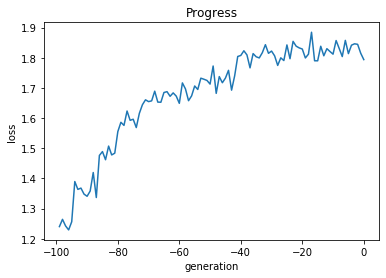

In [114]:
# Evolutionary optimization iterations

SolutionSpace = cnt1
# print(len(l))


# Generating initial solution set
sol_list = []
for i in range(InitNumSol):
    sol_list.append([0, list(random.sample(SolutionSpace, num_weights))])

# max_till_now = sol_list[0]
progress = {} #For plotting
iterations_data = [] # snaping data from intermediate iterations
interStep = 5 # iteration steps after snapping data

#iterating through generations
while(max_gen>0):
    max_gen = max_gen - 1
    ind = random.randint(0,len(test_labels1) - k - 1)
    
    # Calculate loss per solution
    for i in range(len(sol_list)):
        sol_list[i][0] = CalculateLoss(sol_list[i][1], ind)
        
    # rank the solutions based on their loss
    sol_list.sort(reverse = True)
    
    # take a snapshot after interStep iterations
    if (max_gen%interStep==0):
        iterations_data.append(sol_list[0])
        
    # collect progress information
    progress[-max_gen] = sol_list[0][0]
    
    # print best fitness value/loss in each iteration
#     print("Top loss: ",sol_list[0][0], " iteration: ", max_gen)
    
    numSolToKeep = int(numSol/2) # number of best solutions to keep (50% in this case)
    # Keep best numSolToKeep solutions
    sol_list2 = sol_list[:numSolToKeep] 
    
    # Generate other half of the solutions
    for j in range(numSol-len(sol_list2)):
        a1 = random.sample(range(numSolToKeep),2)
        
        sol_list2.append(GenerateNewSol(sol_list[a1[0]],sol_list[a1[1]],SolutionSpace))

    # Use this solution list for next iteration
    sol_list = sol_list2
    

lists = sorted(progress.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Progress')
plt.ylabel('loss')
plt.xlabel('generation')
plt.show()

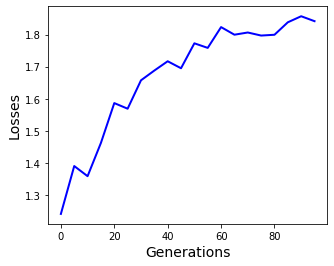

In [117]:
# Ploting the optimization progression in a clear manner
lists = sorted(progress.items()) # sorted by key, return a list of tuples
max_gen=100
x, y = zip(*lists) # unpack a list of pairs into two tuples
xl=[]
yl=[]
for i in range(len(x)):
    if i%5==0: # data after each 5 iterations
        xl.append(x[i] + max_gen - 1)
        yl.append(y[i])


fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(xl, yl, color='blue',linewidth=2)
# ax.set_title('Loss optimization using Evolutionary algorithm', fontsize=18)
ax.set_xlabel('Generations', fontsize=14)
ax.set_ylabel('Losses', fontsize=14)
# leg = ax.legend(fontsize=12)
# plt.savefig("Layer_0_genetic_progress_fashionMnist_50.png")
plt.show()

In [118]:
# testing loss and corresponding model accuracy for a solution
dictx = {}
# x = np.transpose(iterations_data)[1][-1] # intermediate solutions at different iteration points
x = sol_list[0][1] #best solution

# organize weights for different layers
for i in x:
    key, val=i[0], i[1]
    if key not in  dictx.keys():
        dictx[key]=[val]
    else:
        dictx[key].append(val)
        
clean_weight = model.get_weights() # get the model weights

w_new = copy.deepcopy(clean_weight) # copy the model weights in a temporary variable

# flip weight bits for the indexes indicated in a solution
for i in dictx.keys():
    w_f = w_new[i].flatten()
    for j in dictx[i]:
        if w_f[j] > 0:
            w_f[j] = -1
        else:
            w_f[j] = 1
    w_new[i] = w_f.reshape(w_new[i].shape)

model.set_weights(w_new) # update the model with changed weights
    
# Calculate loss of the updated model with a test sample
pred = model.predict(test_images[ind:ind+k])
cce = tf.keras.losses.CategoricalCrossentropy()
loss_new = cce(test_labels1[ind:ind+k],pred).numpy()

print("Updated model loss : ",loss_new) # print loss

# Calculate accuracy of the updated model
from sklearn import metrics
y_pred = model.predict(test_images[:])
y_classes_pred = [np.argmax(element) for element in y_pred]
y_classes_act = [np.argmax(element) for element in test_labels1[:]]
confusion_matrix=metrics.confusion_matrix(test_labels, y_classes_pred)

count=0
for i in range (len(test_labels)):
    if (y_classes_pred[i] == test_labels[i]):
        count = count + 1
print("Updated model accuracy : ",count/len(test_labels)*100)

acc_drop_l = []
for i in range(len(confusion_matrix)):
    acc_drop_l.append(confusion_matrix[i][i]/sum(confusion_matrix[i]))

model.set_weights(cc_weight) # revert the model changes and update to the original one
print("Confusion matrix: ")
print(confusion_matrix)   
print("Class specific accuracies : ",acc_drop_l) # Class specific accuracies

Updated model loss :  1.7940352
Updated model accuracy :  39.050000000000004
Confusion matrix: 
[[457   0 147   8  14   0 153   0 221   0]
 [ 15 519   7  38  12   0  37   0 372   0]
 [ 12   0 820   4   7   0 137   0  20   0]
 [ 26  14  17 297  17   0 151   0 478   0]
 [ 12   0 247  21 226   0 423   0  71   0]
 [  5   0  11  11   8  44   8   0 910   3]
 [ 89   1 175  14  48   0 561   0 111   1]
 [  0   0   0   0   0   2   0   1 992   5]
 [  2   1  69   7   4   0  14   0 903   0]
 [  0   0   2   9  12   0   8   0 892  77]]
Class specific accuracies :  [0.457, 0.519, 0.82, 0.297, 0.226, 0.044, 0.561, 0.001, 0.903, 0.077]
